In [169]:
using OptimalTransport, VegaLite, LinearAlgebra, DataFrames, Distances, LaTeXStrings, Tulip, Distributions, StatsBase
using Distributions
using Plots
using QuadGK
using FillArrays
using LazyArrays
using BenchmarkTools
using Random
using Polynomials

using JuMP

optimizer = Tulip.Optimizer();

In [2]:
sig = 1e-2
μ  = MvNormal([0.2,0.3],I*sig)
ν1 = MvNormal([0.6,0.7],I*sig*0.7)
ν2 = MvNormal([0.7,0.4],I*sig*0.7)
ν  = MixtureModel(MvNormal[ν1,ν2], [0.5, 0.5]);

In [3]:
n = 20
p = 20
x = range(0,1,length=n)
y = range(0,1,length=n)
rho= 0.05

f(x,y) = pdf(μ,[x,y]) >= rho ? pdf(μ,[x,y]) : 0.0
g(x,y) = pdf(ν,[x,y]) >= rho ? pdf(ν,[x,y]) : 0.0
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
z = map(f, X, Y);
z = z./sum(z)
μ_supp = hcat(reshape(X,:,1),reshape(Y,:,1))
μ_p    = hcat(reshape(z,:,1))


w = map(g, X, Y)
w = w./sum(w)
ν_supp = hcat(reshape(X,:,1),reshape(Y,:,1))
ν_p    = hcat(reshape(w,:,1));

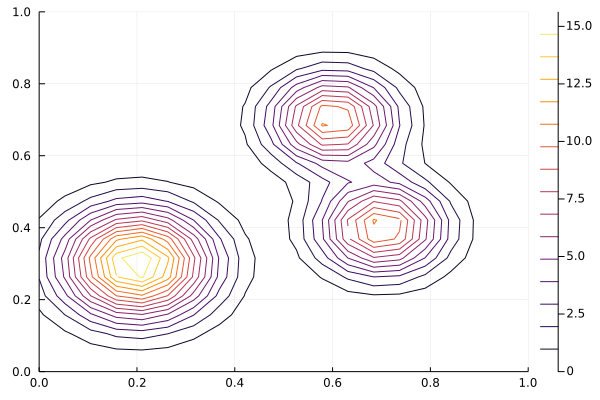

In [4]:
contour(x,y,f)
contour!(x,y,g)

## 1D Case Benamou-Brenier

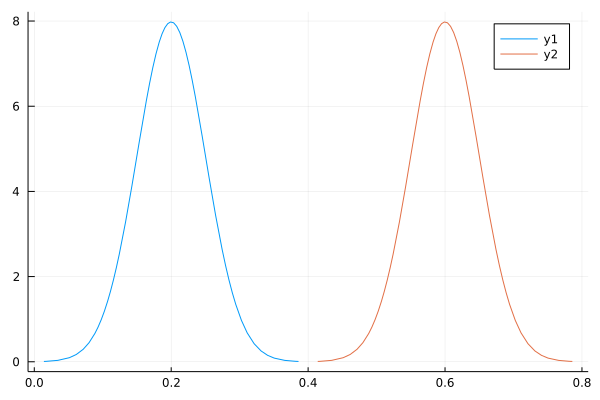

In [28]:
using StatsPlots
μ = Normal(0.2,0.05)
ν = Normal(0.6,0.05)
plot(μ)
plot!(ν)

In [73]:
N = 10
P = 10
Gc_pos  = range(0,1,length=N+1)
Gc_time = range(0,1,length=P+1)

0.0:0.1:1.0

In [74]:
Gxs_pos  = collect((-1:1:N) .+ 1/2 )./N
Gxs_time = collect((0:1:P)./P)


Gts_pos  = collect((0:1:N)./N)
Gts_time = collect((-1:1:P) .+ 1/2 )./P;

In [106]:
length(Gts_pos)
length(Gts_time)

12

In [94]:
f0 = pdf(μ, Gts_pos)
f0[f0 .< 0.01] .= 0
f1 = pdf(ν, Gts_pos)
f1[f1 .< 0.01] .= 0;

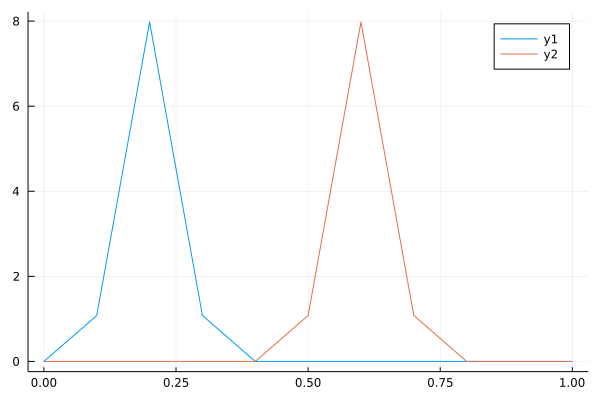

In [96]:
p1 = plot(Gts_pos,f0)
p1 = plot!(Gts_pos,f1)

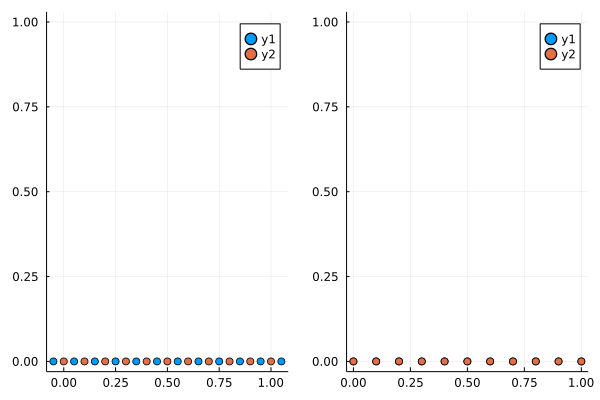

In [97]:
p1 = scatter(Gxs_pos,zeros(N))
p1 = scatter!(Gc_pos,zeros(N))
p2 = scatter(Gxs_time,zeros(N))
p2 = scatter!(Gc_time,zeros(N))
plot(p1,p2)

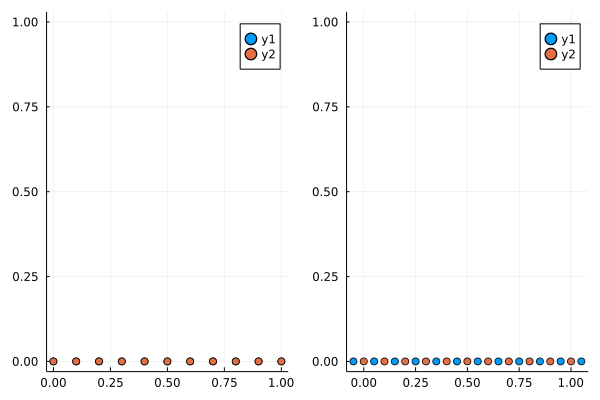

In [98]:
p1 = scatter(Gts_pos,zeros(N))
p1 = scatter!(Gc_pos,zeros(N))
p2 = scatter(Gts_time,zeros(N))
p2 = scatter!(Gc_time,zeros(N))
plot(p1,p2)

In [164]:
function J(m,f)
    if f > 0
        return (m^2)/(2*f)
    elseif m ≈ 0 && f ≈ 0
        return 0
    else
        return Inf
    end
end

J (generic function with 1 method)

In [167]:
# Calculate values in the centered grid
function I!(Esm, Esf,Ecm, Ecf, N, P)
    for i in 1:N+1
        for j in 1:P+1
            Ecm[i,j] = (Esm[i+1,j]+Esm[i,j])/2
        end
    end
    for j in 1:P+1
        for i in 1:N+1
            Ecf[i,j] = (Esf[i,j+1]+Esf[i, j])/2
        end
    end
end

I! (generic function with 2 methods)

In [166]:
function divEs(Esm, Esf, N, P)
    divU = zeros(N+1, P+1)
    for i in 1:N+1
        for j in 1:P+1
            divU[i,j] = N*(Esm[i+1,j]-Esm[i,j]) + P*(Esf[i,j+1] - Esf[i,j])
        end
    end
    return divU
end

divEs (generic function with 1 method)

In [219]:
Ecm = zeros(N+1,P+1)
Ecf = zeros(N+1,P+1)
Esm = zeros(N+2,P+1)
Esf = zeros(N+1,P+2)
function setboundary!(Esm, Esf, f0, f1,N, P)
    Esm[1,:]   .= 0
    Esm[N+2,:] .= 0
    Esf[:,1]    = f0
    Esf[:,P+2]  = f1
end

function b(Esm, Esf)
    return (Esm[1,:], Esm[end,:], Esf[:,1], Esf[:,end])
end

b (generic function with 1 method)

In [224]:
setboundary!(Esm, Esf, f0, f1, N, P)
b0 = b(Ecm,Ecf)
∇U = divEs(Esm, Esf, N, P)
I!(Esm, Esf,Ecm,Ecf, N, P)

In [221]:
Ecm
Ecf
∇U

11×11 Matrix{Float64}:
   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 -10.7982  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 -79.7885  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 -10.7982  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  10.7982
   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  79.7885
   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  10.7982
   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0

In [ ]:
prox(mtilde, ftilde) = 

In [212]:
function proxJ(mtilde, ftilde, γ=1)
    p = Polynomial([γ/2*mtilde^2-ftilde*γ^2, γ^2 - 2*ftilde*γ, -ftilde + 2*γ, 1])
    f = sort(roots(p))[end]
    if f > 0
        m = f*mtilde/(f+ γ)
        return f,m
    else
        return 0,0
    end
end

proxJ (generic function with 2 methods)

In [213]:
γ=0
mtilde = 0
ftilde = 10
p = Polynomial([γ/2*mtilde^2-ftilde*γ^2, γ^2 - 2*ftilde*γ, -ftilde + 2*γ, 1])
roots(p)[1]

10.0

In [214]:
proxJ(mtilde, ftilde)

(10.0, 0.0)

In [216]:
proxJ.(Ecm,Ecf)

11×11 Matrix{Tuple{Real, Real}}:
 (0, 0)          (0, 0)  (0, 0)  (0, 0)  …  (0, 0)  (0, 0)  (0, 0)
 (0.53991, 0.0)  (0, 0)  (0, 0)  (0, 0)     (0, 0)  (0, 0)  (0, 0)
 (3.98942, 0.0)  (0, 0)  (0, 0)  (0, 0)     (0, 0)  (0, 0)  (0, 0)
 (0.53991, 0.0)  (0, 0)  (0, 0)  (0, 0)     (0, 0)  (0, 0)  (0, 0)
 (0, 0)          (0, 0)  (0, 0)  (0, 0)     (0, 0)  (0, 0)  (0, 0)
 (0, 0)          (0, 0)  (0, 0)  (0, 0)  …  (0, 0)  (0, 0)  (0.53991, 0.0)
 (0, 0)          (0, 0)  (0, 0)  (0, 0)     (0, 0)  (0, 0)  (3.98942, 0.0)
 (0, 0)          (0, 0)  (0, 0)  (0, 0)     (0, 0)  (0, 0)  (0.53991, 0.0)
 (0, 0)          (0, 0)  (0, 0)  (0, 0)     (0, 0)  (0, 0)  (0, 0)
 (0, 0)          (0, 0)  (0, 0)  (0, 0)     (0, 0)  (0, 0)  (0, 0)
 (0, 0)          (0, 0)  (0, 0)  (0, 0)  …  (0, 0)  (0, 0)  (0, 0)

## This is the integral which we want to minimize

In [158]:
sum(J.(Ecm, Ecf))

true